**Results - Regression on experimental events**

This notebook is the primary source of plots and tables for the regression part of the thesis, 
with the goal of keeping every table and figure as standardized as possible. (And who has the time to update
90 tables one by one anyway).

**Questions:**
* Descriptive statistics
    - Should descriptive statistics of the simulated data be included?\
    If so, how much? And should it be included for each fold in the k-fold cross-validation?
* Classification results
    - Breakdown of results based on event type? Single, double, close double?
    Reasonable to include in order to confirm the assumption that close doubles are the
    most difficult event type to classify correctly in simulated data
    Random state is included, so should be simple to reproduce the indices


**TODO**
* Implement reproducing the validation indices for each fold based on the random seed from config

**Handy links**
* [matplotlib-plots to latex](https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/)
* [Robert's thesis df output](https://github.com/ATTPC/VAE-event-classification/blob/master/src/make_classification_table.py)

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from master_scripts.data_functions import *
from master_scripts.analysis_functions import *
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

THESIS_PATH = "../../../master_thesis/"
section_path = "chapters/results/figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load experimental set and normalize
repo_root = get_git_root()
events, images = import_real_data(repo_root + "data/real/anodedata_500k.txt") # images not normalized

# normalize each event type separately
descriptors = list(set([event['event_descriptor'] for event in events.values()]))
image_indices = {}
for d in descriptors:
    img_idx = np.array([event['image_idx'] for event in events.values() if event['event_descriptor'] == d])
    # append labeled doubles to decays for normalization.
    if d == 16:
        image_indices[2] = np.concatenate((image_indices[2], img_idx), axis=0)
    else:
        image_indices[d] = img_idx
for indices in image_indices.values():
    images[indices] = normalize_image_data(images[indices])

In [10]:
def classify(model, images, events, threshold=0.5):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(images)
    y_pred = (y_out > threshold).astype(int)
    for event_id in events.keys():
        if y_pred[events[event_id]['image_idx']] == 0:
            events[event_id]['event_class'] = "single"
        else:
            events[event_id]['event_class'] = "double"

    return events
    
def classification_metrics(model, images, events, name, threshold=0.5):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(images)
    y_pred = (y_out > threshold).astype(int)
    for event_id in events.keys():
        if y_pred[events[event_id]['image_idx']] == 0:
            events[event_id]['event_class'] = "single"
        else:
            events[event_id]['event_class'] = "double"
            
    descriptors = list(set([event['event_descriptor'] for event in events.values()]))
    
    desc_class = {'single': [], 'double': []}
    for event in events.values():
        desc_class[event['event_class']].append(event['event_descriptor'])
    
    translate_descriptor = {
        1: "Implant",
        2: "Decay",
        3: "implant + Decay",
        4: "Light ion",
        5: "Implant + Light Ion",
        6: "Decay + Light Ion",
        7: "Implant + Decay + Light Ion",
        8: "Double (time)",
        9: "Implant + Double (time)",
        10: "Decay + Double (time)",
        11: "Implant + Decay + Double (time)",
        12: "Light ion + Double (time)",
        13: "Implant + Light Ion + Double (time)",
        14: "Decay + Light ion + Double (time)",
        15: "Implant + Decay + Light Ion + Double (time)",
        16: "Double (space)",
        17: "Implant + Double (space)",
        18: "Decay + Double (space)"
    }
    
    results = {}
    for d in descriptors:
        num_s = desc_class['single'].count(d)
        num_d = desc_class['double'].count(d)
        tot = num_s + num_d
        norm_s = num_s / tot
        norm_d = num_d / tot
        results[translate_descriptor[d]] = [
            num_s,
            num_d,
            norm_s,
            norm_d
        ]
    
    cols = ["Predicted single", "Predicted double", "Normalized single", "Normalized double"]
    df = pd.DataFrame.from_dict(data=results, orient='index', columns=cols)
    return df


def regression_position(model, events, images, name):
    """ Position regression on experimental data.
    """
    
    prediction = model.predict(images)   
    df = pd.DataFrame.from_dict(
        data={
            name + "_pos1": prediction[:, 0],
            name + "_pos2": prediction[:, 1],
        }
    ).rename(index={i: k for i, k in enumerate(events.keys())})
    return df

def regression_energy(model, events, images, name):
    """ Energy regression on experimental data.
    """
    
    prediction = model.predict(images)
    df = pd.DataFrame(
        data={name + "_e1": prediction.reshape(prediction.shape[0])},
        index=events.keys()
    )
    return df

In [11]:
# Experiment id's
experiments_nomod = {
    'linreg_pos_single': "6f482ad9fe9c",
    'dense_pos_single': "cfbd0c21511a",
    'cnn_pos_single': "4b6620824337",
    'pretrained_pos_single': "9d2a595aaf29",
    'custom_pos_single': "5f3792c8f1a0",
    'linreg_pos_double': "6aa4a4c86271",
    'dense_pos_double': "4e1e812b5ecc",
    'cnn_pos_double': "897838d20a59",
    'pretrained_pos_double': "f0c8443c4f1f",
    'custom_pos_double': "9e0e52034147",
    'linreg_energy_single': "08ae31d8e295",
    'dense_energy_single': "a1796d7f5a79",
    'cnn_energy_single': "266870a6918c",
    'pretrained_energy_single': "db783df32018",
    'custom_energy_single': "1df05215dd0f",
    'linreg_energy_double': "316536f29c50",
    'dense_energy_double': "fddd96776642",
    'cnn_energy_double': "783c1c5d243a",
    'pretrained_energy_double': "a342ac515982",
    'custom_energy_double': "fe9206498a0c",
}
experiments_pixelmod = {
    'linreg_pos_single': "68bf60283e44",
    'dense_pos_single': "755662cc4968",
    'cnn_pos_single': "f049229882a6",
    'pretrained_pos_single': "67884378eed5",
    'custom_pos_single': "d22d8cf06af5",
    'linreg_pos_double': "acfb12d8e5c9",
    'dense_pos_double': "7ec5ca894adc",
    'cnn_pos_double': "336783ab5d3a",
    'pretrained_pos_double': "a6adc3dda8ea",
    'custom_pos_double': "57a4d0c4e961",
    'linreg_energy_single': "110752ceb2dc",
    'dense_energy_single': "1ad5251dad3a",
    'cnn_energy_single': "0620841ee4f8",
    'pretrained_energy_single': "57482c0ae0df",
    'custom_energy_single': "685eb9c5ce0d",
    'linreg_energy_double': "dd9ebe869015",
    'dense_energy_double': "db3151b952e9",
    'cnn_energy_double': "037a360e93b3",
    'pretrained_energy_double': "505fe4eb821b",
    'custom_energy_double': "f5645df3dc7e",
}

experiments_imbalanced = {
    'linreg_pos_single': "2253faab0aad",
    'dense_pos_single': "9d6687876aed",
    'cnn_pos_single': "75a5b5dcb248",
    'pretrained_pos_single': "62e99a102779",
    'custom_pos_single': "ebb4e144b648",
    'linreg_pos_double': "5397fe597104",
    'dense_pos_double': "70321a55db34",
    'cnn_pos_double': "5ee6765687b2",
    'pretrained_pos_double': "7cc270cd9f65",
    'custom_pos_double': "0455e97a0fa9",
    'linreg_energy_single': "2b5f8f9116e6",
    'dense_energy_single': "4c8bff08c890",
    'cnn_energy_single': "f2578e244e47",
    'pretrained_energy_single': "6d74c09833d0",
    'custom_energy_single': "d535f64740b8",
    'linreg_energy_double': "368a0a3775d1",
    'dense_energy_double': "74d82fe449a6",
    'cnn_energy_double': "5c11ddfe6ca9",
    'pretrained_energy_double': "7a80d3b25ea8",
    'custom_energy_double': "0a93befd27dc",
}

# Pre-processed simulated data - no additional modifications
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.

## Single events

### Positions

#### Linear Regression

In [12]:
# Load linear regression experiment
lin_ex_id = experiments_nomod['linreg_pos_single']
lin_ex = load_experiment(lin_ex_id)

# Load model and predict
lin_model = tf.keras.models.load_model(repo_root + "models/" + lin_ex_id + ".h5", compile=False)
lin_test_pos = regression_position(lin_model, events, images.reshape(images.shape[0], 256), "lin_test_pos")
del lin_model #No longer needed, clear memory just in case.

#### Small dense network

In [13]:
# Load logistic regression experiment
dense_ex_id = experiments_nomod['dense_pos_single']
dense_ex = load_experiment(dense_ex_id)

# Load model and predict
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_pos = regression_position(dense_model, events, images.reshape(images.shape[0], 256), "dense_test_pos")
del dense_model

#### Small CNN

In [14]:
# Load logistic regression experiment
cnn_ex_id = experiments_nomod['cnn_pos_single']
cnn_ex = load_experiment(cnn_ex_id)
# Load model and predict
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_pos = regression_position(cnn_model, events, images, "cnn_test_pos")
del cnn_model

#### Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes an issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [15]:
# Load pretrained regression experiment
pretrained_ex_id = experiments_nomod['pretrained_pos_single']
pretrained_ex = load_experiment(pretrained_ex_id)
# Load model and predict
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_pos = regression_position(pretrained_model, events, np.concatenate((images, images, images), axis=-1), "pretrained_test_pos")
del pretrained_model

#### Custom model

In [16]:
# Load custom regression experiment
custom_ex_id = experiments_nomod['custom_pos_single']
custom_ex = load_experiment(custom_ex_id)
# Load model and predict
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_pos = regression_position(custom_model, events, images, "custom_test_pos")
del custom_model

#### Output
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [17]:
all_test_pos = pd.concat(
    [
        lin_test_pos,
        dense_test_pos,
        cnn_test_pos,
        pretrained_test_pos,
        custom_test_pos
    ],
    axis=1,
)
display(all_test_pos)

,lin_test_pos_pos1,lin_test_pos_pos2,dense_test_pos_pos1,dense_test_pos_pos2,cnn_test_pos_pos1,cnn_test_pos_pos2,pretrained_test_pos_pos1,pretrained_test_pos_pos2,custom_test_pos_pos1,custom_test_pos_pos2
0,0.065895,0.000000,1.007314,0.424647,0.500976,0.440802,0.436350,0.371515,0.411006,0.308740
2,0.666483,0.639290,0.959272,0.797956,1.325025,0.981024,0.925300,0.702680,0.808203,0.653062
5,0.930381,0.000000,0.390809,0.479679,0.613283,0.452141,0.589307,0.320150,0.808758,0.198328
10,0.000000,0.000000,1.819935,0.721267,0.678247,0.402865,0.457636,0.333137,0.332290,0.087978
11,0.000000,0.000000,2.457597,0.555793,0.647211,0.198644,0.608061,0.520323,0.266097,0.080396
...,...,...,...,...,...,...,...,...,...,...
2076977,0.000000,0.000000,4.389050,0.421700,0.385511,0.929432,0.755784,1.099710,0.218306,0.543479
2076984,0.318833,0.000000,0.870061,0.399360,0.538235,0.488649,0.459547,0.484398,0.514747,0.452576
2076988,0.571541,0.577129,0.442501,0.639158,0.371655,0.701343,0.419176,0.554258,0.420300,0.528862
2076992,0.000000,0.000000,1.631547,0.478863,0.678003,0.538489,0.417874,0.506559,0.230117,0.270060


### Energy

#### Linear regression

In [18]:
# Load linear regression experiment
lin_ex_id = experiments_nomod['linreg_energy_single']
lin_ex = load_experiment(lin_ex_id)

# Load model and predict
lin_model = tf.keras.models.load_model(repo_root + "models/" + lin_ex_id + ".h5", compile=False)
lin_test_energy = regression_energy(lin_model, events, images.reshape(images.shape[0], 256), "lin_test_energy")
del lin_model #No longer needed, clear memory just in case.

#### Small dense network

In [19]:
# Load dense regression experiment
dense_ex_id = experiments_nomod['dense_energy_single']
dense_ex = load_experiment(dense_ex_id)
# Load model and predict
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_energy = regression_energy(dense_model, events, images.reshape(images.shape[0], 256), "dense_test_energy")
del dense_model

#### Small CNN

In [20]:
# Load cnn regression experiment
cnn_ex_id = experiments_nomod['cnn_energy_single']
cnn_ex = load_experiment(cnn_ex_id)
# Load model and predict
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_energy = regression_energy(cnn_model, events, images, "cnn_test_energy")
del cnn_model

#### Pretrained - VGG16 

In [21]:
# Load logistic regression experiment
pretrained_ex_id = experiments_nomod['pretrained_energy_single']
pretrained_ex = load_experiment(pretrained_ex_id)
# Load model and predict
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_energy = regression_energy(pretrained_model, events, np.concatenate((images, images, images), axis=-1), "pretrained_test_energy")
del pretrained_model

#### Custom model

In [22]:
# Load custom regression experiment
custom_ex_id = experiments_nomod['custom_energy_single']
custom_ex = load_experiment(custom_ex_id)
# Load model and predict
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_energy = regression_energy(custom_model, events, images, "custom_test_energy")
del custom_model

#### Output

In [23]:
all_test_energy = pd.concat(
    [
        lin_test_energy,
        dense_test_energy,
        cnn_test_energy,
        pretrained_test_energy,
        custom_test_energy
    ],
    axis=1
)
display(all_test_energy)

,lin_test_energy_e1,dense_test_energy_e1,cnn_test_energy_e1,pretrained_test_energy_e1,custom_test_energy_e1
0,2.342611,2.301328,2.416928,1.505233,2.246776
2,0.203200,0.202435,0.164204,0.204546,0.220116
5,2.281461,2.241866,2.322294,1.414036,2.143212
10,5.084812,4.974137,5.418475,2.716637,4.799275
11,7.692668,7.515417,8.136841,4.118719,7.280422
...,...,...,...,...,...
2076977,11.179512,10.915904,11.674428,5.603264,10.295860
2076984,2.405223,2.363956,2.485647,1.474539,2.324011
2076988,0.037954,0.036210,0.019011,0.039279,0.035318
2076992,5.349105,5.231980,5.657452,2.916156,5.027160


# Pre-processed simulated data - Pixel modified
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

## Single events

### Positions

#### Linear Regression

In [24]:
# Load linear regression experiment
lin_ex_id = experiments_pixelmod['linreg_pos_single']
lin_ex = load_experiment(lin_ex_id)

# Load model and predict
lin_model = tf.keras.models.load_model(repo_root + "models/" + lin_ex_id + ".h5", compile=False)
lin_test_pos_pmod = regression_position(lin_model, events, images.reshape(images.shape[0], 256), "lin_test_pos_pmod")
del lin_model

#### Small dense network

In [25]:
# Load logistic regression experiment
dense_ex_id = experiments_pixelmod['dense_pos_single']
dense_ex = load_experiment(dense_ex_id)
# Load model and predict
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_pos_pmod = regression_position(dense_model, events, images.reshape(images.shape[0], 256), "dense_test_pos_pmod")
del dense_model

#### Small CNN

In [26]:
# Load logistic regression experiment
cnn_ex_id = experiments_pixelmod['cnn_pos_single']
cnn_ex = load_experiment(cnn_ex_id)
# Load model and predict
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_pos_pmod = regression_position(cnn_model, events, images, "cnn_test_pos_pmod")
del cnn_model

#### Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes an issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [27]:
# Load logistic regression experiment
pretrained_ex_id = experiments_pixelmod['pretrained_pos_single']
pretrained_ex = load_experiment(pretrained_ex_id)
# Load model and predict
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_pos_pmod = regression_position(pretrained_model, events, np.concatenate((images, images, images), axis=-1), "pretrained_test_pos_pmod")
del pretrained_model

#### Custom model

In [28]:
# Load custom regression experiment
custom_ex_id = experiments_pixelmod['custom_pos_single']
custom_ex = load_experiment(custom_ex_id)
# Load model and predict
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_pos_pmod = regression_position(custom_model, events, images, "custom_test_pos_pmod")
del custom_model

#### Output
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [29]:
all_test_pos_pmod = pd.concat(
    [
        lin_test_pos_pmod,
        dense_test_pos_pmod,
        cnn_test_pos_pmod,
        pretrained_test_pos_pmod,
        custom_test_pos_pmod
    ],
    axis=1,
)
display(all_test_pos_pmod)

,lin_test_pos_pmod_pos1,lin_test_pos_pmod_pos2,dense_test_pos_pmod_pos1,dense_test_pos_pmod_pos2,cnn_test_pos_pmod_pos1,cnn_test_pos_pmod_pos2,pretrained_test_pos_pmod_pos1,pretrained_test_pos_pmod_pos2,custom_test_pos_pmod_pos1,custom_test_pos_pmod_pos2
0,0.000000,0.000000,0.205978,0.336584,0.378605,0.426969,0.460840,0.371366,0.436463,0.262442
2,0.669610,0.637326,0.970757,1.117380,1.375708,0.974781,0.880490,0.673239,0.700175,0.676170
5,0.426650,0.000000,0.048443,0.255578,0.551956,0.480952,0.688870,0.312973,0.773591,0.234493
10,0.000000,0.000000,-0.698358,1.195301,0.413113,0.409219,0.458075,0.275861,0.147291,0.390212
11,0.000000,0.000000,-1.227685,1.298893,0.326056,0.260334,0.576399,0.425368,0.236916,0.259151
...,...,...,...,...,...,...,...,...,...,...
2076977,0.000000,0.000000,-0.323654,-1.007149,-0.171607,0.785067,0.688886,1.015332,0.378516,0.407264
2076984,0.000000,0.000000,0.250247,0.328525,0.479614,0.489656,0.491442,0.501995,0.374281,0.480927
2076988,0.569454,0.575265,0.390797,0.783844,0.359294,0.701308,0.409099,0.540967,0.417242,0.532328
2076992,0.000000,0.000000,-0.506572,0.395623,0.333462,0.407920,0.398149,0.481063,0.200777,0.301803


### Energy

#### Linear regression

In [30]:
# Load linear regression experiment
lin_ex_id = experiments_pixelmod['linreg_energy_single']
lin_ex = load_experiment(lin_ex_id)

# Load model and predict
lin_model = tf.keras.models.load_model(repo_root + "models/" + lin_ex_id + ".h5", compile=False)
lin_test_energy_pmod = regression_energy(lin_model, events, images.reshape(images.shape[0], 256), "lin_test_energy_pmod")
del lin_model

#### Small dense network

In [31]:
# Load dense regression experiment
dense_ex_id = experiments_pixelmod['dense_energy_single']
dense_ex = load_experiment(dense_ex_id)
# Load model and predict
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_energy_pmod = regression_energy(dense_model, events, images.reshape(images.shape[0], 256), "dense_test_energy_pmod")
del dense_model

#### Small CNN
This is really sensitive to pixel modifications.
Performs similarly to the other models if you pixelmod the test data.

In [32]:
# Load cnn regression experiment
cnn_ex_id = experiments_pixelmod['cnn_energy_single']
cnn_ex = load_experiment(cnn_ex_id)

cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_energy_pmod = regression_energy(cnn_model, events, images, "cnn_test_energy_pmod")
del cnn_model

#### Pretrained - VGG16 

In [33]:
# Load logistic regression experiment
pretrained_ex_id = experiments_pixelmod['pretrained_energy_single']
pretrained_ex = load_experiment(pretrained_ex_id)
# Load model and predict
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_energy_pmod = regression_energy(pretrained_model, events, np.concatenate((images, images, images), axis=-1), "pretrained_test_energy_pmod")
del pretrained_model

#### Custom model

In [34]:
# Load custom regression experiment
custom_ex_id = experiments_pixelmod['custom_energy_single']
custom_ex = load_experiment(custom_ex_id)
# Load model and predict
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_energy_pmod = regression_energy(custom_model, events, images, "custom_test_energy_pmod")
del custom_model

#### Output

In [35]:
all_test_energy_pmod = pd.concat(
    [
        lin_test_energy_pmod,
        dense_test_energy_pmod,
        cnn_test_energy_pmod,
        pretrained_test_energy_pmod,
        custom_test_energy_pmod
    ],
    axis=1
)
display(all_test_energy_pmod)

,lin_test_energy_pmod_e1,dense_test_energy_pmod_e1,cnn_test_energy_pmod_e1,pretrained_test_energy_pmod_e1,custom_test_energy_pmod_e1
0,2.141244,2.173106,2.138443,1.691590,2.708882
2,0.196273,0.149650,0.157705,0.217861,0.278016
5,2.123577,2.197093,2.148047,1.695737,2.477580
10,4.755063,4.907210,5.053217,3.132912,5.414234
11,7.233776,7.477028,7.893335,4.781569,7.497864
...,...,...,...,...,...
2076977,10.679149,11.148499,11.967105,6.979602,9.869400
2076984,2.191205,2.230606,2.201130,1.690323,2.923197
2076988,0.035377,0.032730,0.019585,0.028798,0.025140
2076992,5.150984,5.400608,5.674596,3.720213,5.708390


# Pre-processed simulated data - Pixel modified and imbalanced
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

This dataset has also been purposefully imbalanced to mimic the properties of experimental data
where doubles in space are expected to be rare.

## Single events

### Positions

#### Linear Regression

In [36]:
# Load linear regression experiment
lin_ex_id = experiments_imbalanced['linreg_pos_single']
lin_ex = load_experiment(lin_ex_id)

# Load model and predict
lin_model = tf.keras.models.load_model(repo_root + "models/" + lin_ex_id + ".h5", compile=False)
lin_test_pos_imbalanced = regression_position(lin_model, events, images.reshape(images.shape[0], 256), "lin_test_pos_imbalanced")
del lin_model

#### Small dense network

In [37]:
# Load logistic regression experiment
dense_ex_id = experiments_imbalanced['dense_pos_single']
dense_ex = load_experiment(dense_ex_id)
# Load model and predict
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_pos_imbalanced = regression_position(dense_model, events, images.reshape(images.shape[0], 256), "dense_test_pos_imbalanced")
del dense_model

#### Small CNN

In [38]:
# Load logistic regression experiment
cnn_ex_id = experiments_imbalanced['cnn_pos_single']
cnn_ex = load_experiment(cnn_ex_id)
# Load model and predict
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_pos_imbalanced = regression_position(cnn_model, events, images, "cnn_test_pos_imbalanced")
del cnn_model

#### Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes an issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [39]:
# Load logistic regression experiment
pretrained_ex_id = experiments_imbalanced['pretrained_pos_single']
pretrained_ex = load_experiment(pretrained_ex_id)
# Load model and predict
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_pos_imbalanced = regression_position(pretrained_model, events, np.concatenate((images, images, images), axis=-1), "pretrained_test_pos_imbalanced")
del pretrained_model

#### Custom model

In [40]:
# Load custom regression experiment
custom_ex_id = experiments_imbalanced['custom_pos_single']
custom_ex = load_experiment(custom_ex_id)
# Load model and predict
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_pos_imbalanced = regression_position(custom_model, events, images, "custom_test_pos_imbalanced")
del custom_model

#### Output
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [41]:
all_test_pos_imbalanced = pd.concat(
    [
        lin_test_pos_imbalanced,
        dense_test_pos_imbalanced,
        cnn_test_pos_imbalanced,
        pretrained_test_pos_imbalanced,
        custom_test_pos_imbalanced
    ],
    axis=1
)
display(all_test_pos_imbalanced)

,lin_test_pos_imbalanced_pos1,lin_test_pos_imbalanced_pos2,dense_test_pos_imbalanced_pos1,dense_test_pos_imbalanced_pos2,cnn_test_pos_imbalanced_pos1,cnn_test_pos_imbalanced_pos2,pretrained_test_pos_imbalanced_pos1,pretrained_test_pos_imbalanced_pos2,custom_test_pos_imbalanced_pos1,custom_test_pos_imbalanced_pos2
0,0.000000,0.000000,0.205984,0.336556,0.373662,0.421747,0.442863,0.369116,0.400217,0.323352
2,0.669610,0.637326,0.970756,1.117382,1.371602,0.972730,0.887915,0.680387,0.830747,0.675071
5,0.426650,0.000000,0.048450,0.255573,0.552894,0.479131,0.680691,0.318081,0.861188,0.183015
10,0.000000,0.000000,-0.698355,1.195216,0.414176,0.403721,0.440061,0.285462,0.320137,0.150134
11,0.000000,0.000000,-1.227671,1.298771,0.322518,0.244305,0.546342,0.444562,0.337153,0.110147
...,...,...,...,...,...,...,...,...,...,...
2076977,0.000000,0.000000,-0.323587,-1.007148,-0.182623,0.776540,0.653463,1.018146,0.124666,0.553900
2076984,0.000000,0.000000,0.250250,0.328520,0.476946,0.487295,0.488227,0.501287,0.423634,0.451761
2076988,0.569454,0.575265,0.390795,0.783843,0.359470,0.700028,0.405038,0.539546,0.418023,0.542181
2076992,0.000000,0.000000,-0.506496,0.395554,0.333131,0.399399,0.374529,0.486257,0.163766,0.292978


### Energy

#### Linear regression

In [42]:
# Load linear regression experiment
lin_ex_id = experiments_imbalanced['linreg_energy_single']
lin_ex = load_experiment(lin_ex_id)

# Load model and predict
lin_model = tf.keras.models.load_model(repo_root + "models/" + lin_ex_id + ".h5", compile=False)
lin_test_energy_imbalanced = regression_energy(lin_model, events, images.reshape(images.shape[0], 256), "lin_test_energy_imbalanced")
del lin_model

#### Small dense network

In [43]:
# Load dense regression experiment
dense_ex_id = experiments_imbalanced['dense_energy_single']
dense_ex = load_experiment(dense_ex_id)
# Load model and predict
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_energy_imbalanced = regression_energy(dense_model, events, images.reshape(images.shape[0], 256), "dense_test_energy_imbalanced")
del dense_model

#### Small CNN

In [44]:
# Load cnn regression experiment
cnn_ex_id = experiments_imbalanced['cnn_energy_single']
cnn_ex = load_experiment(cnn_ex_id)
# Load model and predict
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_energy_imbalanced = regression_energy(cnn_model, events, images, "cnn_test_energy_imbalanced")
del cnn_model

#### Pretrained - VGG16 

In [45]:
# Load logistic regression experiment
pretrained_ex_id = experiments_imbalanced['pretrained_energy_single']
pretrained_ex = load_experiment(pretrained_ex_id)
# Load model and predict
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_energy_imbalanced = regression_energy(pretrained_model, events, np.concatenate((images, images, images), axis=-1), "pretrained_test_energy_imbalanced")
del pretrained_model

#### Custom model

In [46]:
# Load custom regression experiment
custom_ex_id = experiments_imbalanced['custom_energy_single']
custom_ex = load_experiment(custom_ex_id)
# Load model and predict
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_energy_imbalanced = regression_energy(custom_model, events, images, "custom_test_energy_imbalanced")
del custom_model

#### Output

In [47]:
all_test_energy_imbalanced = pd.concat(
    [
        lin_test_energy_imbalanced,
        dense_test_energy_imbalanced,
        cnn_test_energy_imbalanced,
        pretrained_test_energy_imbalanced,
        custom_test_energy_imbalanced
    ],
    axis=1
)
display(all_test_energy_imbalanced)

,lin_test_energy_imbalanced_e1,dense_test_energy_imbalanced_e1,cnn_test_energy_imbalanced_e1,pretrained_test_energy_imbalanced_e1,custom_test_energy_imbalanced_e1
0,2.141244,2.173106,2.071454,1.682552,2.739499
2,0.196273,0.149650,0.147488,0.218063,0.281477
5,2.123577,2.197093,2.110739,1.685228,2.453859
10,4.755064,4.907209,4.845081,3.108175,5.033611
11,7.233775,7.477027,7.529574,4.741507,6.923042
...,...,...,...,...,...
2076977,10.679149,11.148501,11.259909,6.933058,9.300753
2076984,2.191205,2.230607,2.127232,1.683164,2.957249
2076988,0.035377,0.032730,0.024452,0.028507,0.035406
2076992,5.150985,5.400608,5.313211,3.691783,5.314437


# Experimental data with DDAS and Fits
Comparisons with simulated data:
* Predicted energy vs. HIP
* Predicted energy vs. sum of pixels

Experimental-only:
* Predicted energy vs DDAS
* Predicted energy vs Fit energy

In [48]:
events_comp, images_comp = import_real_energy_data(repo_root + "data/real/decaydata_100k.txt")


# load predictions from other notebook on comp_events
df_energy_comp = pd.read_hdf("experimental_energy_100k.h5", "df")
ddas_energies = np.array([events_comp[k]['ddas_energy'] for k in events_comp.keys()])
fit_energies = np.array([events_comp[k]['fit_energy'] for k in events_comp.keys()])

# Combined tables

In [49]:
df_pos = pd.concat(
    [
        all_test_pos,
        all_test_pos_pmod,
        all_test_pos_imbalanced
    ],
    axis=1
)

df_energy = pd.concat(
    [
        all_test_energy,
        all_test_energy_pmod,
        all_test_energy_imbalanced
    ],
    axis=1
)

df_pos.to_hdf("experimental_pos_500k.h5", "df", "w")
df_energy.to_hdf("experimental_energy_500k.h5", "df", "w")
print(df_pos.shape)
print(df_energy.shape)

(499999, 30)
(499999, 15)


## Position 'metrics'
Using the highest intensity pixel location as a guideline for where we expect the positions to appear.
Looking only at decays

In [61]:
decays = [e['image_idx'] for e in events.values() if e['event_descriptor'] == 2]

In [62]:
# === Get location of highest intensity pixels in the images
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get indices of max values along the columns.

max_idx = images[decays].reshape(images[decays].shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images[decays].shape))

In [66]:
cols = df_pos.columns
dists = {}
for i in range(0, len(cols), 2):
    pos1 = df_pos.iloc[decays][cols[i]]*16
    pos2 = df_pos.iloc[decays][cols[i+1]]*16
    dist = np.sqrt((maxpos_vect[:, 1] - pos1)**2 + (maxpos_vect[:, 2] - pos2)**2)
    dists[cols[i][:-4] + "dist"] = dist
df_dist = pd.DataFrame(data=dists)*3

In [67]:
# Get minimum mean distance model and value
min_col = df_dist.describe().loc["mean"].idxmin()
min_mean = df_dist[min_col].mean()

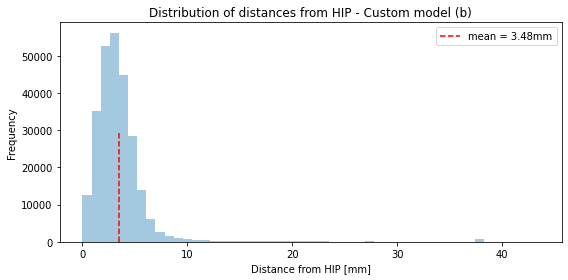

In [68]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df_dist['custom_test_pos_pmod_dist'], kde=False, ax=ax)
ax.set_xlabel("Distance from HIP [mm]")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of distances from HIP - Custom model (b)")
ax.axvline(min_mean, ymax=0.5, c='r', ls='--', label=r"mean = {:.2f}mm".format(min_mean))
ax.legend()
fig.tight_layout()
plt.savefig(THESIS_PATH + section_path + 'experimental_pos_dist.pdf')

In [69]:
df_dist_means = df_dist.mean().rename(index={
    "lin_test_pos_dist": "LinReg (a)",
    "dense_test_pos_dist": "Dense (a)",
    "cnn_test_pos_dist": "CNN (a)",
    "pretrained_test_pos_dist": "Pretrained (a)",
    "custom_test_pos_dist": "Custom (a)",
    "lin_test_pos_pmod_dist": "LinReg (b)",
    "dense_test_pos_pmod_dist": "Dense (b)",
    "cnn_test_pos_pmod_dist": "CNN (b)",
    "pretrained_test_pos_pmod_dist": "Pretrained (b)",
    "custom_test_pos_pmod_dist": "Custom (b)",
    "lin_test_pos_imbalanced_dist": "LinReg (c)",
    "dense_test_pos_imbalanced_dist": "Dense (c)",
    "cnn_test_pos_imbalanced_dist": "CNN (c)",
    "pretrained_test_pos_imbalanced_dist": "Pretrained (c)",
    "custom_test_pos_imbalanced_dist": "Custom (c)",
})

rows = df_dist_means.index
dist_means_array = np.zeros((df_dist_means.shape), dtype=object)
for i in range(df_dist_means.shape[0]):
    dist_means_array[i] = r"$\num{{ {:.2f} }}$".format(df_dist_means.iloc[i])
        
df_dist_means_array = pd.DataFrame(dist_means_array, index=rows, columns=["Mean distance [mm]"])

# Output dist mean df
section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "regression_experimental_dist_means.tex"
caption = """
Mean distances of predicted position of origin on experimental decays, to center of highest intensity pixel (HIP).Models 
trained on data with: a) no modifications, b) specific pixels set to zero to mimic experimental data, and c) imbalanced dataset
in addition to modifications in b) to further mimic experimental data.
"""
label = "tab:regression-experimental-dist-means"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    df_dist_means_array.to_latex(fp, escape=False, caption=caption, label=label, index=True)

# Energy comp outputs
The regression models have effectively been trained on the exact same data, as they are only trained on single
events, and single events are the same across both pmod and imbalanced datasets. With fixed random_seed, they
are initialized identically and trained identically, so this is to be expected.

The true difference thus lies between 

In [55]:
# ddas_energies, fit_energies, df_energy_comp

# Calculate ddas and fit slope and intercept for a linear fit, for each model
polyfits = {}
for col in df_energy_comp:    
    a_ddas, b_ddas = np.polyfit(ddas_energies, df_energy_comp[col], 1)
    a_fit, b_fit = np.polyfit(fit_energies, df_energy_comp[col], 1)
    polyfits[col] = [a_ddas, b_ddas, a_fit, b_fit]
    
df_polyfit = pd.DataFrame(data=polyfits, index=["a_ddas", "b_ddas", "a_fit", "b_fit"])

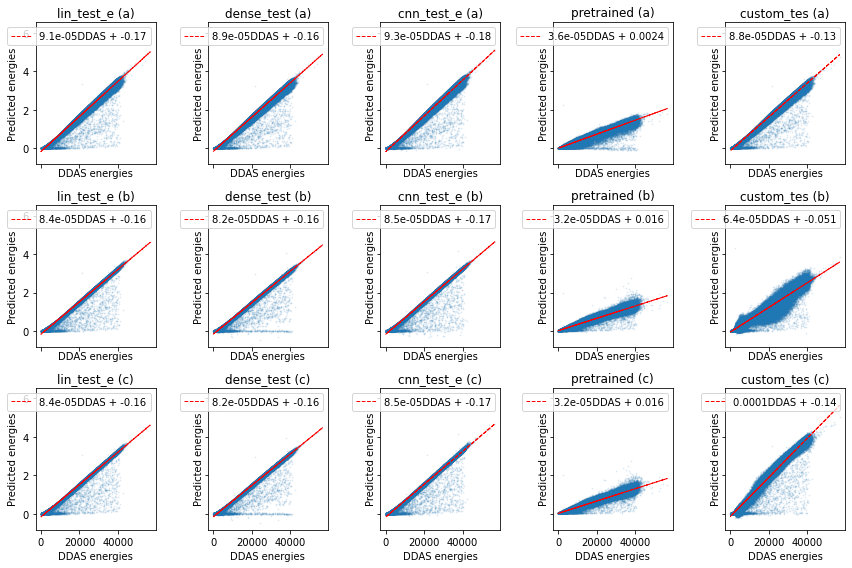

In [56]:
# make a stupid amount of plots with ddas energies
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(12,8))
mod = ["(a)"]*5 + ["(b)"]*5 + ["(c)"]*5
for i, col in enumerate(df_energy_comp):
    a_ddas, b_ddas = df_polyfit[col][:2]
    ax.flatten()[i].scatter(ddas_energies, df_energy_comp[col], alpha=0.1, s=0.75)
    ax.flatten()[i].plot(ddas_energies, a_ddas*ddas_energies  + b_ddas, 'r--', lw=1, label='{:.2g}DDAS + {:.2g}'.format(a_ddas, b_ddas))
    ax.flatten()[i].set_xlabel("DDAS energies")
    ax.flatten()[i].set_ylabel("Predicted energies")
    ax.flatten()[i].set_title(col[:10] + " " + mod[i])
    ax.flatten()[i].legend()
fig.tight_layout()
    
    
    

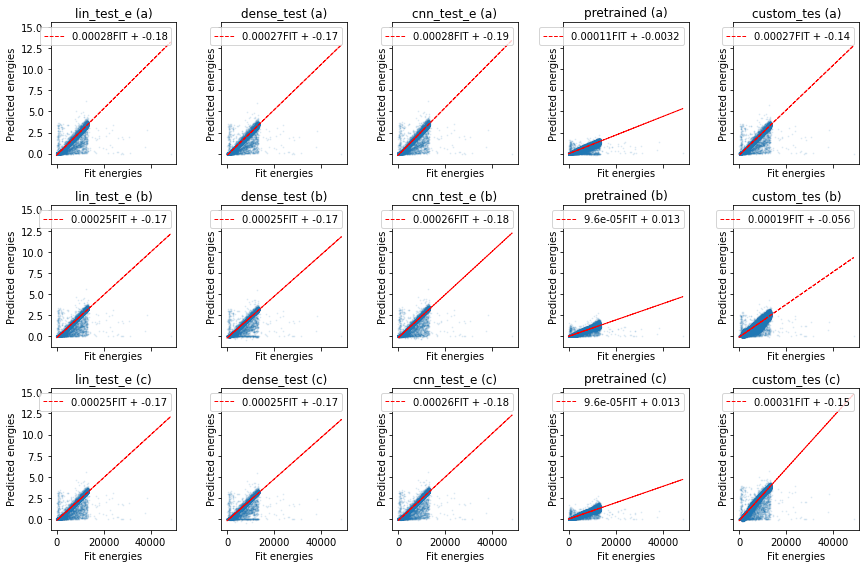

In [57]:
# make a stupid amount of plots with fit energies
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(12,8))
mod = ["(a)"]*5 + ["(b)"]*5 + ["(c)"]*5
for i, col in enumerate(df_energy_comp):
    a_fit, b_fit = df_polyfit[col][2:]
    ax.flatten()[i].scatter(fit_energies, df_energy_comp[col], alpha=0.1, s=0.75)
    ax.flatten()[i].plot(fit_energies, a_fit*fit_energies  + b_fit, 'r--', lw=1, label='{:.2g}FIT + {:.2g}'.format(a_fit, b_fit))
    ax.flatten()[i].set_xlabel("Fit energies")
    ax.flatten()[i].set_ylabel("Predicted energies")
    ax.flatten()[i].set_title(col[:10] + " " + mod[i])
    ax.flatten()[i].legend()
fig.tight_layout()

In [58]:
display(df_polyfit)

,lin_test_energy_e1,dense_test_energy_e1,cnn_test_energy_e1,pretrained_test_energy_e1,custom_test_energy_e1,lin_test_energy_pmod_e1,dense_test_energy_pmod_e1,cnn_test_energy_pmod_e1,pretrained_test_energy_pmod_e1,custom_test_energy_pmod_e1,lin_test_energy_imbalanced_e1,dense_test_energy_imbalanced_e1,cnn_test_energy_imbalanced_e1,pretrained_test_energy_imbalanced_e1,custom_test_energy_imbalanced_e1
a_ddas,0.000091,0.000089,0.000093,0.000036,0.000088,0.000084,0.000082,0.000085,0.000032,0.000064,0.000084,0.000082,0.000085,0.000032,0.000102
b_ddas,-0.171323,-0.158491,-0.177041,0.002356,-0.127457,-0.163173,-0.156226,-0.168415,0.016336,-0.050534,-0.163173,-0.156847,-0.172782,0.016336,-0.137699
a_fit,0.000275,0.000269,0.000281,0.000110,0.000266,0.000253,0.000246,0.000255,0.000096,0.000193,0.000253,0.000246,0.000257,0.000096,0.000307
b_fit,-0.182692,-0.169747,-0.188299,-0.003153,-0.138515,-0.171900,-0.165180,-0.177327,0.013480,-0.055931,-0.171900,-0.165793,-0.181402,0.013479,-0.151537
